In [1]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name="hedge_fund_series")
df.set_index("Unnamed: 0", inplace=True)
df.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Unnamed: 0,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027034,-0.006491
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022143
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025242
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028607,-0.007963
2011-12-31,-0.004479,0.001938,0.001796,0.012874,0.001818


In [5]:
# 1
def performance_stat(s: pd.Series) -> pd.Series:
    """
    Calculate the mean, volatility, sharpe of given series
    
    Parameters:
        s (pd.Series): 
            Excess return of certain asset / portfolio
            Index: all time period (i.e. monthly)
            
    Returns:
        s_stat: Series contains mean, volatility, sharpe of the input series
    """
    s_stat = s.agg(['mean', 'std']).T
    s_stat['mean'] *= 12
    s_stat['std'] *= (12 ** (1/2))
    s_stat['sharpe'] = s_stat['mean'] / s_stat['std']
    return s_stat

performance_stat(df)

,mean,std,sharpe
HFRIFWI Index,0.043223,0.060228,0.717668
MLEIFCTR Index,0.031885,0.056966,0.559721
MLEIFCTX Index,0.030399,0.056806,0.535142
HDG US Equity,0.020513,0.059367,0.345534
QAI US Equity,0.019611,0.050062,0.391729


In [47]:
# 2
from functools import partial

def cvar(s: pd.Series, q: float = 0.05) -> float:
    """
    Calculate the mean of the returns at or below the q quantile
    
    Parameters:
        s (pd.Series): 
            Return series of certain asset
        q (float):
            quantile used to calculate CVaR
            
    Returns:
        CVaR value of input asset returns
    """
    return s.loc[s < np.quantile(s, q=q)].mean()

df.agg(['skew', 'kurt', partial(np.quantile, q=0.05, axis=0), cvar]).T.rename(columns={"quantile": "VaR"})

,skew,kurt,VaR,cvar
HFRIFWI Index,-0.983171,5.918307,-0.025130,-0.037478
MLEIFCTR Index,-0.255827,1.664342,-0.028656,-0.035857
MLEIFCTX Index,-0.241814,1.631565,-0.028927,-0.035816
HDG US Equity,-0.243959,1.780069,-0.031158,-0.037576
QAI US Equity,-0.458360,1.737586,-0.020086,-0.032696


In [48]:
def max_drawdown(s: pd.Series) -> pd.Series:
    """
    Calculate the maximum drawdown, peak date, trough date, and recovery date
    
    Parameters:
        s (pd.Series): 
            Return series of certain asset
            
    Returns:
        pd.Series of all statistics of given asset
    """
    s_cum = (s + 1).cumprod()
    s_cum_max = s_cum.cummax()
    pct_to_peak = s_cum / s_cum_max - 1
    drawdown = min(pct_to_peak)
    trough_date = pct_to_peak[pct_to_peak == drawdown].index[0]
    peak_cum = s_cum_max[pct_to_peak == drawdown][0]
    peak_date = s_cum[s_cum == peak_cum].index[0]
    is_recovered = (s_cum.index > trough_date) & (s_cum >= peak_cum)
    recovery_date = s_cum.loc[is_recovered].index[0] if any(is_recovered) else None
    
    return pd.Series({
        "drawdown": drawdown, 
        "trough_date": trough_date, 
        "peak_date": peak_date, 
        "recovery_date": recovery_date
    })

df.apply(max_drawdown).T

,drawdown,trough_date,peak_date,recovery_date
HFRIFWI Index,-0.115473,2020-03-31,2019-12-31,2020-08-31
MLEIFCTR Index,-0.124302,2022-09-30,2021-06-30,NaT
MLEIFCTX Index,-0.124388,2022-09-30,2021-06-30,NaT
HDG US Equity,-0.140721,2022-09-30,2021-06-30,NaT
QAI US Equity,-0.137716,2022-09-30,2021-06-30,NaT


In [69]:
# 3
from sklearn.linear_model import LinearRegression

df_factor = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name="merrill_factors")
df_factor.set_index("Unnamed: 0", inplace=True)
df.index.name = "Date"

In [70]:
def linear_regression_stat(s: pd.Series) -> pd.Series:
    """
    Run linear regression of certain asset returns against merrill factors
    and calculate Market Beta / Treynor Ratio / Information Ratio
    
    Parameters:
        s (pd.Series): 
            Return series of certain asset
            
    Returns:
        pd.Series of all annualized statistics of given asset
    """
    reg = LinearRegression().fit(df_factor[['SPY US Equity']], s)
    market_beta = reg.coef_[0]
    error_std = np.std(s - reg.predict(df_factor[['SPY US Equity']]))
    return pd.Series({
        "market_beta": market_beta,
        "treynor_ratio": s.mean() * 12 / market_beta,
        "information_ratio": reg.intercept_ / error_std
    })

df.apply(linear_regression_stat).T

,market_beta,treynor_ratio,information_ratio
HFRIFWI Index,0.348706,0.123954,-0.029121
MLEIFCTR Index,0.349620,0.091199,-0.168095
MLEIFCTX Index,0.348325,0.087273,-0.182956
HDG US Equity,0.359366,0.057082,-0.285016
QAI US Equity,0.296053,0.066241,-0.227235


<Axes: title={'center': 'Index Comparison'}>

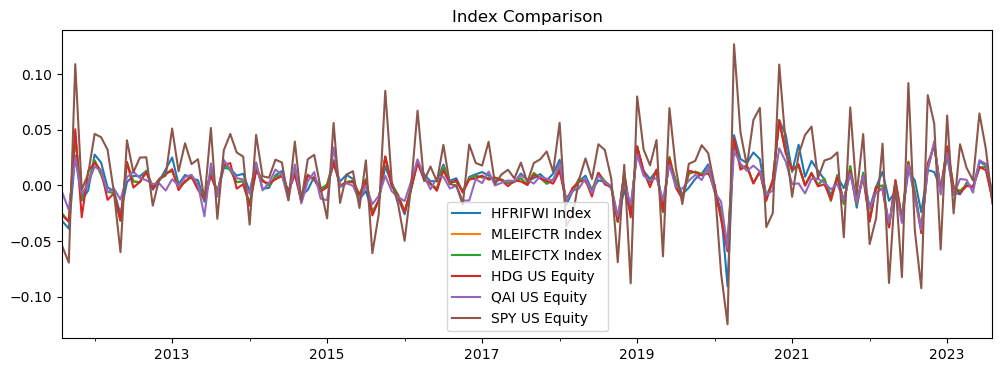

In [71]:
# 4
"""
1. HDG is most related to SPY. But overall, none of the series is highly correlated with SPY.
2. By treynor and information ratio, QAI is slightly better.
3. No. Because ML / HDG series has much lower treynor and information ratio compared to HFRI.
"""

# 4.1
pd.concat([df, df_factor[['SPY US Equity']]], axis=1).plot(title="Index Comparison", figsize=(12, 4))

Highest correlation: ('MLEIFCTR Index', 'MLEIFCTX Index'); Lowest correlation: ('QAI US Equity', 'HFRIFWI Index')


<Axes: >

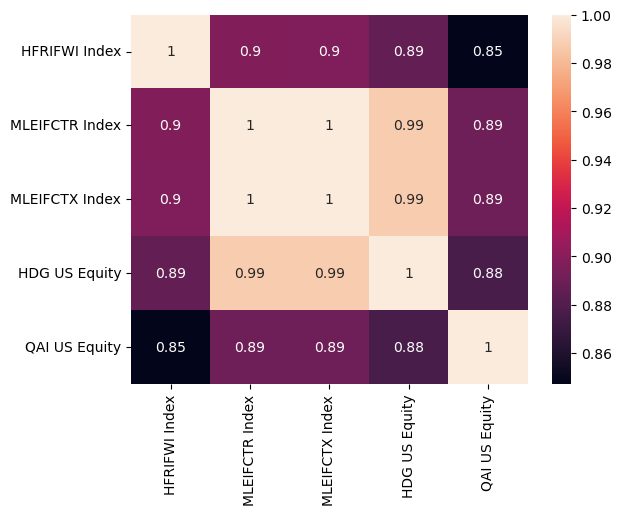

In [83]:
# 5
def correlation_stat(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate correlation between assets and print highest and lowest correlations pair
    
    Parameters:
        df (pd.DataFrame): 
            Asset returns df.
            Columns: all assets
            Index: all time period (i.e. monthly)
    Returns: 
        pd.DataFrame of correlation matrix
    """
    df_corr = df.corr()
    df_corr_unstack = df_corr.unstack().sort_values()
    df_corr_unstack = df_corr_unstack[df_corr_unstack.index.get_level_values(0) != 
                                      df_corr_unstack.index.get_level_values(1)]
    print(f"Highest correlation: {df_corr_unstack.index[-1]}; Lowest correlation: {df_corr_unstack.index[0]}")
    return df_corr
    
df_corr = correlation_stat(df)

import seaborn as sns
sns.heatmap(df_corr, annot=True)

In [92]:
# 6
reg = LinearRegression().fit(df_factor, df[["HFRIFWI Index"]])

# 6.a.
pd.Series({
    "intercept": reg.intercept_[0], 
    **dict(zip(reg.feature_names_in_.tolist(), reg.coef_.tolist()[0]))
}, name="value")

intercept        0.001383
SPY US Equity    0.033308
USGG3M Index    -0.165908
EEM US Equity    0.077857
EFA US Equity    0.082410
EUO US Equity    0.022649
IWM US Equity    0.152074
Name: value, dtype: float64

In [95]:
# 6.b. 
sum_position = np.sum(np.abs(reg.coef_))
print("Beta is {}realistic, total position to replicate is {:.4f}.".format(
    'not ' if sum_position > 3 else '', sum_position))

Beta is realistic, total position to replicate is 0.5342.


In [96]:
# 6.c.
print("R2 is {:4f}".format(reg.score(df_factor, df[["HFRIFWI Index"]])))

R2 is 0.836901


In [103]:
# 6.d.
print("Tracking error is {:.4f}.".format(np.std(df[["HFRIFWI Index"]] - reg.predict(df_factor))[0]))

Tracking error is 0.0070


In [151]:
# 7
def rolling_pred(s: pd.Series):
    df_x = df_factor.loc[s.index]
    reg = LinearRegression().fit(df_x.iloc[:-1], s.iloc[:-1])
    return reg.predict(df_x.iloc[[-1]])
    
df_oos_pred = df["HFRIFWI Index"].rolling(61).apply(rolling_pred)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
is_oos = df_oos_pred.notnull()
pd.Series({
    "tracking_error": np.std(df.loc[is_oos, "HFRIFWI Index"] - df_oos_pred.loc[is_oos]),
    "MSE": mean_squared_error(df.loc[is_oos, "HFRIFWI Index"], df_oos_pred.loc[is_oos]),
    "MAE": mean_absolute_error(df.loc[is_oos, "HFRIFWI Index"], df_oos_pred.loc[is_oos]),
    "R2": r2_score(df.loc[is_oos, "HFRIFWI Index"], df_oos_pred.loc[is_oos]),
}, name="OOS Stat")

# Based on calculated statistics below, OOS portfolio replicates target pretty well.

tracking_error    0.008418
MSE               0.000073
MAE               0.005976
R2                0.803525
Name: OOS Stat, dtype: float64

In [152]:
# 8
import statsmodels.api as sm

res = sm.OLS(df["HFRIFWI Index"], df_factor).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          HFRIFWI Index   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.833
Method:                 Least Squares   F-statistic:                              121.6
Date:                Fri, 06 Oct 2023   Prob (F-statistic):                    8.97e-53
Time:                        23:33:14   Log-Likelihood:                          512.07
No. Observations:                 145   AIC:                                     -1012.
Df Residuals:                     139   BIC:                                     -994.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [159]:
# 8.a.
res.params.to_frame("without_intercept").assign(with_intercept=reg.coef_.tolist()[0])

# Most obvious changes is beta for USGG3M increase negative -0.17 (with intercept) to positive 0.33 (without). Market beta also increase when we remove intercept. 

,without_intercept,with_intercept
SPY US Equity,0.050858,0.033308
USGG3M Index,0.337787,-0.165908
EEM US Equity,0.077639,0.077857
EFA US Equity,0.075253,0.082410
EUO US Equity,0.025636,0.022649
IWM US Equity,0.148556,0.152074


In [163]:
# 8.b.
pd.Series({
    "actual": df["HFRIFWI Index"].mean() * 12,
    "fitted": res.predict().mean() * 12
}, name="mean")

# Fitted mean is roughly 1% lower than actual mean.

actual    0.043223
fitted    0.033082
Name: mean, dtype: float64

In [171]:
# 8.c.
pd.Series({
    "with_intercept": np.correlate(df["HFRIFWI Index"], reg.predict(df_factor)[:, 0])[0],
    "without_intercept": np.correlate(df["HFRIFWI Index"], res.predict())[0],
}, name="corr")

# Correlation between fitted values and actual values are very similar regardless whether we includes intercept.

with_intercept       0.038310
without_intercept    0.038141
Name: corr, dtype: float64

In [ ]:
"""
Proshares should be fitting without intercept, because:
1. Exhibit 4 shows Proshare is longing US debt, which is consistent with USGG3M's beta when fitted without intercept.
2. Exhibit 3 shows ProShare has a 1.3% lower one year return than benchmark, similar to our estimation in 8.b.
"""